# (Try to) Extract Gentrification-Relevant Tweets using a Large Language Model

Apply an LLM to a dataset of historic tweets to try to extract those that might be indicative of some kind of gentrification.

## Libraries

In [1]:
import os
import re

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point

#from kaggle.api.kaggle_api_extended import KaggleApi  # pip install kaggle
from together import Together  # pip install together

# Access to Hugging Face data
#conda install huggingface::datasets
#conda install huggingface::huggingface_hub
#from huggingface_hub import login
#from datasets import load_dataset


# Easier display options for debugging: 

# Set the display width to a larger value
pd.set_option('display.width', 1000)

# Optionally, set the max column width to avoid truncating column data
pd.set_option('display.max_colwidth', None)

# Optionally, set the max number of columns to show all columns
pd.set_option('display.max_columns', None)

## Open test data

Currently use a historic library of tweets that were downloaded using various APIs by the researchers.

In [2]:
# Read a small sample dataset I created for testing 
#tweets_df = pd.read_csv(os.path.join("..", "data", "uk_tweets", "uk_tweets-2017-02-15.sample.csv"),
#                        quotechar='"',
#                        skipinitialspace=True)

# Read the full dataset, but optionally skip loads of rows to make it smaller
# (in future read the whole thing and then start to filter, e.g. by removing tweets without coordinates or outside the study area)
num_skip = 1000  # Read only one in every num_skip rows
tweets_df = pd.read_csv(
    os.path.join("..", "data", "uk_tweets", "uk_tweets-2017-02-15.csv"),
    quotechar='"',
    skipinitialspace=True,
    skiprows=lambda x: x != 0 and x % num_skip != 0  # Skip rows that aren't 0 (need the header) or where they're not a multiple of num_skip
)

In [3]:
print(tweets_df.columns)
tweets_df

Index(['id', 'user-id', 'user-screen_name', 'geo-coordinates-0', 'geo-coordinates-1', 'coordinates-coordinates-0', 'coordinates-coordinates-1', 'place-full_name', 'created_at', 'text', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second'], dtype='object')


id             user-id user-screen_name  geo-coordinates-0  geo-coordinates-1  coordinates-coordinates-0  coordinates-coordinates-1          place-full_name                      created_at                                                                                                                                      text  Year  Month  Day  Hour  Minute  Second
0       672784137867104257          1236556939   BruhItsShannon                NaN                NaN                        NaN                        NaN         Leyland_ England  Fri Dec 04 14:26:52 +0000 2015                                                                                         I'll slice your fingers off one by one üòäüòäüòäüòäüòäüòäüòäüòäüòäüòä  2015     12    4    14      26      52
1       672784968440020992           269913251  ReInventionRoom                NaN                NaN                        NaN                        NaN       Stirling_ Scotland  Fri Dec 04 14:30:10 +0000 2015    Remember I am in @sainsburys #stirling as your personal #stylist tom 10-2 @SainsburysNews @manager_marc @Mrstirling01 #style #lookgood  2015     12    4    14      30      10
2       672785791324725248           716187074        rossitude                NaN                NaN                        NaN                        NaN  Leamington Spa_ England  Fri Dec 04 14:33:27 +0000 2015                                                                                       @DanielJRound nooooo! ....I never say the l word üòâüòé  2015     12    4    14      33      27
3       672786608165412864           285017157        mhairijay                NaN                NaN                        NaN                        NaN        Glasgow_ Scotland  Fri Dec 04 14:36:41 +0000 2015                                                                                           @Miridoesntweet neither https://t.co/CL02assLeV  2015     12    4    14      36      41
4       672787427426222080          2811007878      StrakerHair          51.536322          -0.243699                  -0.243699                  51.536322            Brent_ London  Fri Dec 04 14:39:57 +0000 2015  Good 2 c @NicolaAWaddell for col by @StrakerHair at @Empyrealstudios #nw10 2day! Rtf! @KensalRiseRA @carysampofo https://t.co/BE4aGoFqdO  2015     12    4    14      39      57
...                    ...                 ...              ...                ...                ...                        ...                        ...                      ...                             ...                                                                                                                                       ...   ...    ...  ...   ...     ...     ...
104738  831475986336272386           544804344   JordanCross335                NaN                NaN                        NaN                        NaN    South Dublin_ Ireland  Tue Feb 14 12:11:37 +0000 2017                                                                                                        Willy Martin and Jenny Hennessyüëåüòçüòç  2017      2   14    12      11      37
104739  831476970215059456  798675808281890816         GrayPone                NaN                NaN                        NaN                        NaN     Dublin City_ Ireland  Tue Feb 14 12:15:32 +0000 2017                                                                                    @TheAuraMaster1 no this cheese https://t.co/xkvh2n4h8F  2017      2   14    12      15      32
104740  831477922313691136            49743959    CharlCunliffe                NaN                NaN                        NaN                        NaN      Manchester_ England  Tue Feb 14 12:19:19 +0000 2017                            Sat in the library drowning in philosophy with an absolute fucking banger of a hangover_ happy Valo's to me üòÇüòò  2017      2   14    12      19      19
104741  831478900685406209  830959383974649857          nommm_1

Select some Tweets from near Glasgow for the Urban Analytics presentation

In [4]:
# Rough bounding box around Glasgow 
lat_min = 55.7   # Slightly south of Glasgow
lat_max = 56.0   # Slightly north of Glasgow
lon_min = -4.5   # Slightly west of Glasgow
lon_max = -4.0   # Slightly east of Glasgow

# Ignore tweets without coordinates
tweets_df_clean = tweets_df.dropna(subset=['geo-coordinates-0', 'geo-coordinates-1']).copy()

# Ensure that latitude and longitude are numeric
tweets_df_clean['geo-coordinates-0'] = pd.to_numeric(tweets_df_clean['geo-coordinates-0'])
tweets_df_clean['geo-coordinates-1'] = pd.to_numeric(tweets_df_clean['geo-coordinates-1'])

# Extract glasgow
gla_df = tweets_df_clean.loc[
    (tweets_df_clean['geo-coordinates-0'] >= lat_min) &
    (tweets_df_clean['geo-coordinates-0'] <= lat_max) &
    (tweets_df_clean['geo-coordinates-1'] >= lon_min) &
    (tweets_df_clean['geo-coordinates-1'] <= lon_max),:
].copy()

# Make a gdf
gla_df['geometry'] = gla_df.apply(
    lambda row: Point(row['geo-coordinates-1'], row['geo-coordinates-0']), axis=1
)
gla_gdf = gpd.GeoDataFrame(gla_df, geometry='geometry', crs='EPSG:4326')  

# Reproject to Web Mercator for Plotting
gla_gdf = gla_gdf.to_crs(epsg=3857)
print(f"Found {len(gla_gdf)} tweets near Glasgow")
gla_gdf


Found 162 tweets near Glasgow


id     user-id user-screen_name  geo-coordinates-0  geo-coordinates-1  coordinates-coordinates-0  coordinates-coordinates-1          place-full_name                      created_at                                                                                                                     text  Year  Month  Day  Hour  Minute  Second                         geometry
1588    675715526388248576    19708944      spizzenergi          55.859262          -4.258055                  -4.258055                  55.859262        Glasgow_ Scotland  Sat Dec 12 16:35:10 +0000 2015    #Glasgow #glasgowcentralstation #gigtonight with #therezillos #spizzenergi #punkrockoriginal‚Ä¶ https://t.co/4BQSA9i8OS  2015     12   12    16      35      10  POINT (-474004.479 7530449.558)
3161    677115026050850817   552762818  JayMcFarlane666          55.852631          -4.281749                  -4.281749                  55.852631        Glasgow_ Scotland  Wed Dec 16 13:16:17 +0000 2015                             Good session last night rory_dempster9 @chrisglover28 @ MGM Scotland https://t.co/nzec2KlDBD  2015     12   16    13      16      17  POINT (-476642.141 7529134.338)
3171    677123495797592064    14234180           jearle          55.700944          -4.027718                  -4.027718                  55.700944      Glassford_ Scotland  Wed Dec 16 13:49:56 +0000 2015                                                                               @Novembervivi Plus not capitalising Allah.  2015     12   16    13      49      56   POINT (-448363.53 7499110.923)
3353    677245828797460481   112192587    CattonWhinger          55.865410          -4.253835                  -4.253835                  55.865410        Glasgow_ Scotland  Wed Dec 16 21:56:02 +0000 2015             @Lord_Sugar Can you not just fire the bloody lot of them and donate the 250 grand to charity? #bbcapprentice  2015     12   16    21      56       2  POINT (-473534.782 7531669.025)
4228    678150717006340096  1290461437      Awesomeon20          55.876114          -4.292992                  -4.292992                  55.876114        Glasgow_ Scotland  Sat Dec 19 09:51:45 +0000 2015                          It's gonna be a great day. #awesome365 #brunch #westend @ Avenue G cafe https://t.co/J87xRrxFN2  2015     12   19     9      51      45  POINT (-477893.695 7533792.863)
...                    ...         ...              ...                ...                ...                        ...                        ...                      ...                             ...                                                                                                                      ...   ...    ...  ...   ...     ...     ...                              ...
101330  827159080515010564  2613663331        DigiDewar          55.850842          -4.233658                  -4.233658                  55.850842        Glasgow_ Scotland  Thu Feb 02 14:17:47 +0000 2017       bethashton from the @katiebutlermen representing #trinitymirror glasgowlive @daily_record‚Ä¶ https://t.co/fltLrxj002  2017      2    2    14      17      47  POINT (-471288.635 7528779.695)
101440  827255866818572296    16199886     keith_wilson          55.878160          -4.273699                  -4.273699                  55.878160        Glasgow_ Scotland  Thu Feb 02 20:42:22 +0000 2017                                                                                @stephen_wigmore Such unbridled optimism.  2017      2    2    20      42      22  POINT (-475746.018 7534198.971)
102706  828762829628989440   377685873         celticCK          55.858000          -4.259000                  -4.259000                  55.858000        Glasgow_ Scotland  Tue Feb 07 00:30:30 +0000 2017  Embracing every second - I'm the luckiest man alive. Thanks again for your ongoing messages of‚Ä¶ https://t.co/vkXpruGn9J  2017      2    7     0      30      30   POINT (-474109.711 7530199.25)
103846  830355246488645632  

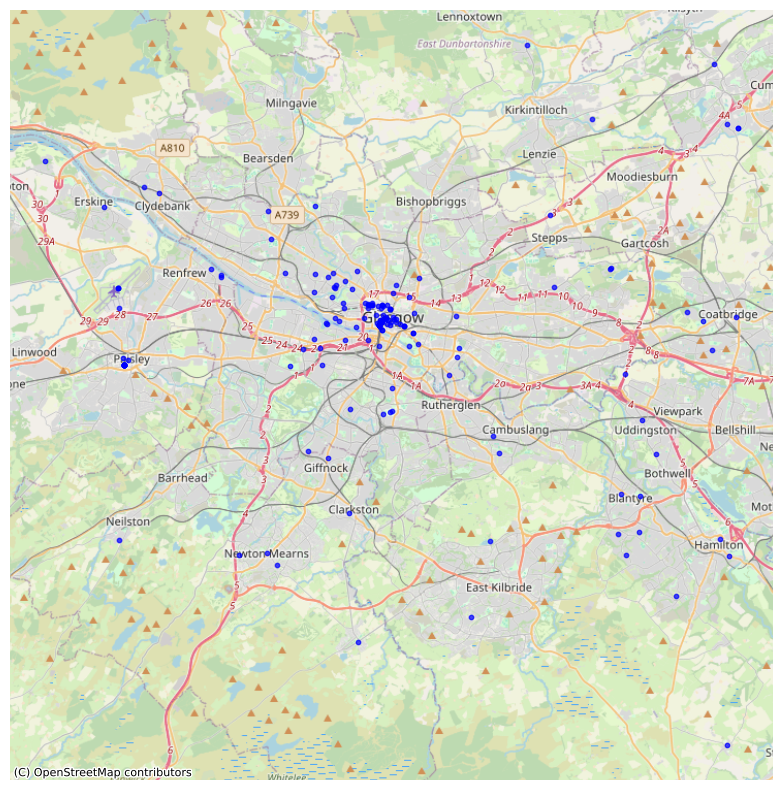

In [5]:
# Plot with a basemap
fig, ax = plt.subplots(figsize=(10, 10))
gla_gdf.plot(ax=ax, marker='o', color='blue', markersize=10, alpha=0.7)
#ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()  # Remove axis for cleaner look
plt.show()

## Use the Together.AI API to batch classify them as how likely they are to be related to gentrification. 

A function that takes a batch of tweets and uses the Together API to classify them. The `_system_prompt` variable contains the prompt that will be sent to the API; individual tweets are appended to this.

The LLM requires some parameter values. Here are the settings that chatGPT recommended (with defaults, that I decided not to use, in brackets)

1.	max_tokens:
	-	Recommendation: 50 (200)
	-	Explanation: Since you‚Äôre expecting short responses like '1. Score', a small max_tokens value ensures concise outputs without unnecessary verbosity.
	-    _(I actually choose a larger value because the prompt has been designed to get the LLM to stop long before max_tokens is reached and this way it is hopefully less likely to break if we increase the batch size.
2.	temperature:
	-	Recommendation: 0.2 (0.7)
	-	Explanation: A lower temperature makes the model‚Äôs output more deterministic, which is ideal for scoring tasks where consistency is important.
3.	top_p:
	-	Recommendation: 0.9 (0.7)
	-	Explanation: This value balances the randomness and coherence of the output by considering tokens with a cumulative probability up to 90%.
4.	top_k:
	-	Recommendation: 40 (50)
	-	Explanation: Limits the model to consider the top 40 probable next tokens, which helps in generating relevant responses.
5.	repetition_penalty:
	-	Recommendation: 1.1 (1)
	-	Explanation: Slightly penalizes repeated tokens to prevent the model from producing redundant information.

In [6]:
_system_prompt = """
Analyze the following tweets to determine their relevance to gentrification.
Consider indicators such as mentions of urban development, demographic shifts, displacement concerns, socioeconomic changes, and cultural transformations.
Assign a score from 1 to 5, where 1 means not suggestive of gentrification and 5 means highly suggestive.
Provide your answer strictly in the format ‚Äò1. Score‚Äô, ‚Äò2. Score‚Äô, etc., without any additional explanation or commentary.
""" 

In [13]:
def get_gentrification_scores(batch_tweets, batch_index=0, system_prompt=_system_prompt):
    """
    Retrieves gentrification scores for a batch of tweets using the Together AI API.

    Parameters
    ----------
    batch_tweets : pandas.DataFrame
        A DataFrame containing the tweets for the current batch. 
        It must include a 'text' column with the tweet content.
    batch_index : int
        An optional starting index of the current batch. 
        This is used to align the predicted sentiments with the original DataFrame indices.
    system_prompt : str
        An optional system prompt to be sent to the Together AI API.
        The tweet texts will be appended to this prompt.

    Returns
    -------
    ids : list of int
        A list of DataFrame indices corresponding to each tweet in the batch. 
        These indices align with the main DataFrame from which this batch was drawn.
    sentiments : list of str
        A list of predicted gentrification scores for each tweet in the batch. 
        Possible values are 1 (not suggestive of gentrification) to 5 (highly suggestive).
    """

    # Prepare the list of tweets
    tweet_list = "\n".join([f"{idx+1}. {tweet}" 
                            for idx, tweet in enumerate(batch_tweets.text.values)])
    
    # Create the system prompt
    system_prompt = f"{system_prompt}\n\n{tweet_list}"
    #print("PROMPT:", system_prompt, "\n\n")

    # Prepare the messages
    messages = [
        {
            "role": "system",
            "content": system_prompt
        }
    ]

    
    # Call the API using parameters that ChatGPT recommends for this task
    response = client.chat.completions.create(
        model="meta-llama/Llama-3.2-90B-Vision-Instruct-Turbo",
        messages=messages,
        max_tokens=200,  # length of output
        temperature=0.2,  # lower for more deterministic
        top_p=0.9,  # ??
        top_k=40,  # ??
        repetition_penalty=1,
        stop=["<|eot_id|>", "<|eom_id|>"],
        truncate=130560,  # ??
        stream=False  # Set stream to False to get the full response
    )

    # Extract the assistant's reply and get the IDs and scores
    assistant_reply = response.choices[0].message.content.strip()
    ids = []
    scores = []

    # re pattern for matches lines like '1. 2' and captures the two numbers
    pattern = r'^\s*(\d+)\s*\.\s*(\d+)\s*$'

    # Analyse the reply line-by-line
    lines = assistant_reply.strip().split('\n')
    error = False  # Return -1s on error 
    for line in lines:
        match = re.match(pattern, line)
        if match:
            # Extract the index and score from the match groups
            index = int(match.group(1))
            score = int(match.group(2))
            # Validate the score range
            if 1 <= score <= 5:
                ids.append(index)
                scores.append(score)
            else:
                print(f"Warning: Score {score} out of range on line: '{line}'")
                error = True
        else:
            print(f"Warning: Invalid format on line: '{line}'")
            error = True
    
    if error:
        scores = [-1] * len(batch_tweets)
    
    # Compute dataframe indices
    df_ids = [batch_index + int(id) - 1 for id in ids]

    #print("ids:", ids)
    #print("scores:", scores)
    return df_ids, scores

    ## Use regular expressions to extract the scores
    #matches = re.findall(r"(\d+)\.\s*(1|2|3|4|5)", assistant_reply, re.IGNORECASE)

    ## Check that the numbering is correct (optional)
    ## You can add code here to verify the numbering matches the tweets

    ## Compute the actual DataFrame indices
    #ids = [batch_index + int(idx) - 1 for idx, score in matches]
    #scores = [int(score) for idx, score in matches]
    #assert len(ids) == len(scores)

    #return ids, scores

In [14]:
# Get the API key from a file
with open('together.ai_key.txt', 'r') as f:
    api_key = f.readline().strip()

client = Together(api_key=api_key)

# List of tweets to classify (can sample if I want to)
#df = tweets_df.sample(100).copy()
df = gla_gdf.copy()

print(f"Will query the LM for {len(df)} tweets")

if len(df) > 1000:
    # Abort!
    print("Too many tweets to process in one go. Please reduce the number of tweets.")
    exit()

# Ensure the index is consecutive and ascending
df = df.reset_index(drop=True)
# To store the results
df['gentrification_prediction'] = None

# Batch processing
batch_size = 20
for i in range(0, len(df), batch_size):
    # Get the batch of tweets
    batch_tweets = df.loc[i:i + batch_size - 1, :]

    # Get sentiments using the function
    print(f"Submitting batch {i//len(batch_tweets)+1} of {len(df)//len(batch_tweets)}...")

    ids, sentiments = get_gentrification_scores(batch_tweets, batch_index=i)
    
    #for idx, score in zip(ids, sentiments):
    #    print(f"\t{idx}: {score}")
    
    # Update the DataFrame with the predictions
    df.loc[ids, 'gentrification_prediction'] = sentiments

print("Finished")

Will query the LM for 162 tweets
Submitting batch 1 of 8...
Submitting batch 2 of 8...
Submitting batch 3 of 8...
Submitting batch 4 of 8...
Submitting batch 5 of 8...
Submitting batch 6 of 8...
Submitting batch 7 of 8...
Submitting batch 8 of 8...
Submitting batch 81 of 81...
Finished


In [12]:
sentiments

[-1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1]

See how well that worked

In [15]:
df.loc[:,['text', 'gentrification_prediction']]

text gentrification_prediction
0      #Glasgow #glasgowcentralstation #gigtonight with #therezillos #spizzenergi #punkrockoriginal‚Ä¶ https://t.co/4BQSA9i8OS                         1
1                               Good session last night rory_dempster9 @chrisglover28 @ MGM Scotland https://t.co/nzec2KlDBD                         1
2                                                                                 @Novembervivi Plus not capitalising Allah.                         1
3               @Lord_Sugar Can you not just fire the bloody lot of them and donate the 250 grand to charity? #bbcapprentice                         1
4                            It's gonna be a great day. #awesome365 #brunch #westend @ Avenue G cafe https://t.co/J87xRrxFN2                         2
..                                                                                                                       ...                       ...
157       bethashton from the @katiebutlermen representing #trinitymirror glasgowlive @daily_record‚Ä¶ https://t.co/fltLrxj002                        -1
158                                                                                @stephen_wigmore Such unbridled optimism.                        -1
159  Embracing every second - I'm the luckiest man alive. Thanks again for your ongoing messages of‚Ä¶ https://t.co/vkXpruGn9J                        -1
160                                           I'm at @CostaCoffee in Glasgow_ Scotland_ Glasgow City https://t.co/0lTVppLKv6                         1
161                                                               I'm at Saint Mary's primary School https://t.co/ktqvbUjh9J                         1

[162 rows x 2 columns]

Plot to have a look at the gentrification prediction scores

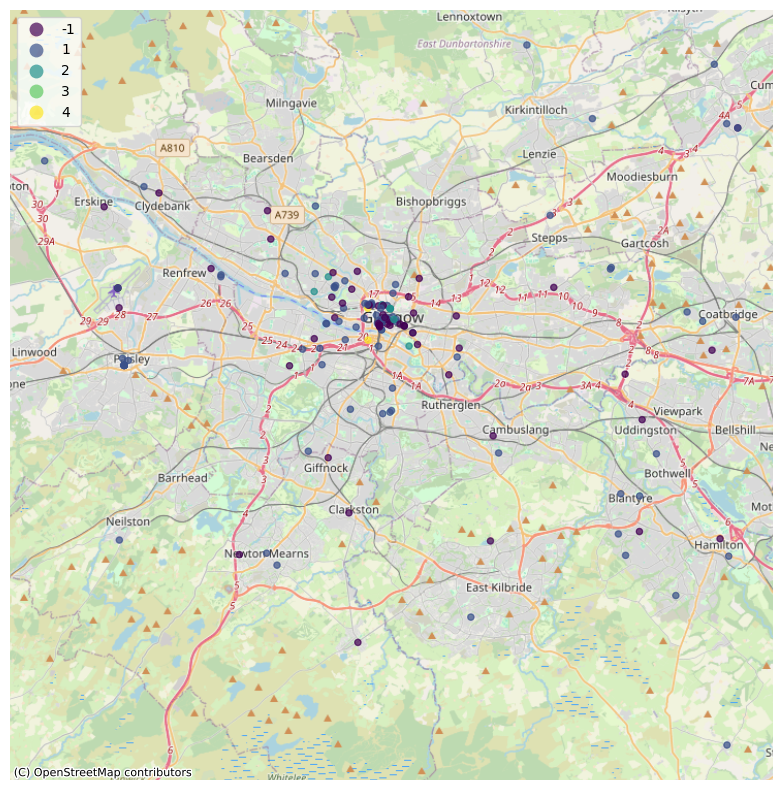

In [27]:
# Plot with a basemap
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame, coloring by 'gentrification_prediction'
df.plot(
    ax=ax,
    marker='o',
    column='gentrification_prediction',
    cmap='viridis',  # You can choose a different colormap if you prefer
    markersize=20,
    alpha=0.7,
    legend=True,  # Add a legend to show the color scale
    #legend_kwds={'title': "Gentrification Prediction", 'orientation': "vertical"}
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Remove axis for cleaner look
ax.set_axis_off()

# Display the plot
plt.show()